# Import Libraries

In [2]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score,
    precision_recall_curve, auc, f1_score, precision_score, recall_score
)
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("✅ Libraries imported successfully!")

✅ Libraries imported successfully!


# Data Loading

In [3]:
# Load the engineered e-commerce data
ecommerce_df = pd.read_csv('../data/cleaned/fraud_data_engineered.csv')
print("E-commerce data shape:", ecommerce_df.shape)
print("E-commerce columns:", ecommerce_df.columns.tolist())

# Load the credit card data
creditcard_df = pd.read_csv('../data/cleaned/creditcard_cleaned.csv')
print("\nCredit card data shape:", creditcard_df.shape)
print("Credit card columns:", creditcard_df.columns.tolist())

E-commerce data shape: (129146, 23)
E-commerce columns: ['user_id', 'signup_time', 'purchase_time', 'purchase_value', 'device_id', 'source', 'browser', 'sex', 'age', 'ip_address', 'class', 'ip_int', 'lower_bound_ip_address', 'upper_bound_ip_address', 'country', 'lower_bound_ip_int', 'upper_bound_ip_int', 'time_since_signup', 'hour_of_day', 'day_of_week', 'tx_count_by_user', 'prev_purchase_time', 'txn_velocity_hours']

Credit card data shape: (283726, 31)
Credit card columns: ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'Class']


# Data Preparation Functions 

In [4]:
def prepare_ecommerce_data(df):
    """
    Prepare e-commerce data for modeling.
    Excludes datetime columns and non-feature columns.
    """
    # Columns to exclude
    exclude_cols = [
        'user_id', 'signup_time', 'purchase_time', 'device_id',
        'ip_address', 'ip_int', 'lower_bound_ip_int', 'upper_bound_ip_int',
        'prev_purchase_time'
    ]
    
    # Select features
    feature_cols = [col for col in df.columns if col not in exclude_cols and col != 'class']
    
    X = df[feature_cols]
    y = df['class']
    
    return X, y, feature_cols

def prepare_creditcard_data(df):
    """
    Prepare credit card data for modeling.
    """
    # Select features (all columns except 'Class')
    feature_cols = [col for col in df.columns if col != 'Class']
    
    X = df[feature_cols]
    y = df['Class']
    
    return X, y, feature_cols

# Prepare both datasets
X_ecom, y_ecom, ecom_features = prepare_ecommerce_data(ecommerce_df)
X_cc, y_cc, cc_features = prepare_creditcard_data(creditcard_df)

print("E-commerce features:", len(ecom_features))
print("Credit card features:", len(cc_features))
print("\nE-commerce class distribution:")
print(y_ecom.value_counts(normalize=True))
print("\nCredit card class distribution:")
print(y_cc.value_counts(normalize=True))

E-commerce features: 13
Credit card features: 30

E-commerce class distribution:
class
0    0.905007
1    0.094993
Name: proportion, dtype: float64

Credit card class distribution:
Class
0    0.998333
1    0.001667
Name: proportion, dtype: float64


 # Model Buildiing Class

In [15]:
class FraudDetectionModel:
    def __init__(self, model_name='logistic_regression', random_state=42):
        self.model_name = model_name
        self.random_state = random_state
        self.model = None
        self.scaler = StandardScaler()
        self.feature_names = None
        self.categorical_cols = None
        self.numerical_cols = None
        
    def create_model(self):
        """Create the specified model"""
        if self.model_name == 'logistic_regression':
            self.model = LogisticRegression(
                random_state=self.random_state,
                max_iter=1000,
                class_weight='balanced'
            )
        elif self.model_name == 'random_forest':
            self.model = RandomForestClassifier(
                n_estimators=100,
                max_depth=10,
                random_state=self.random_state,
                class_weight='balanced',
                n_jobs=-1
            )
        else:
            raise ValueError(f"Unknown model: {self.model_name}")
    
    def train_with_categorical(self, X_train, y_train, X_test, y_test, categorical_cols, numerical_cols):
        """Train the model with proper categorical handling"""
        # Create model
        self.create_model()
        
        # Store column information
        self.categorical_cols = categorical_cols
        self.numerical_cols = numerical_cols
        self.feature_names = X_train.columns.tolist()
        
        # Handle categorical variables - convert to numeric
        X_train_processed = X_train.copy()
        X_test_processed = X_test.copy()
        
        # Convert categorical to numeric using label encoding
        for col in categorical_cols:
            if col in X_train_processed.columns:
                # Create a mapping from unique values to integers
                unique_values = X_train_processed[col].unique()
                value_mapping = {val: idx for idx, val in enumerate(unique_values)}
                
                # Apply mapping
                X_train_processed[col] = X_train_processed[col].map(value_mapping)
                X_test_processed[col] = X_test_processed[col].map(value_mapping)
                
                # Fill any missing values (new categories in test set)
                X_test_processed[col] = X_test_processed[col].fillna(-1)
        
        # Scale numerical features only
        if numerical_cols:
            X_train_scaled = X_train_processed.copy()
            X_test_scaled = X_test_processed.copy()
            
            # Scale numerical columns
            X_train_scaled[numerical_cols] = self.scaler.fit_transform(X_train_processed[numerical_cols])
            X_test_scaled[numerical_cols] = self.scaler.transform(X_test_processed[numerical_cols])
        else:
            X_train_scaled = X_train_processed
            X_test_scaled = X_test_processed
        
        # Train model
        self.model.fit(X_train_scaled, y_train)
        
        # Make predictions
        y_pred = self.model.predict(X_test_scaled)
        y_pred_proba = self.model.predict_proba(X_test_scaled)[:, 1]
        
        return y_pred, y_pred_proba, X_test_scaled
    
    def evaluate(self, y_true, y_pred, y_pred_proba):
        """Evaluate model performance"""
        # Calculate metrics
        precision = precision_score(y_true, y_pred)
        recall = recall_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred)
        roc_auc = roc_auc_score(y_true, y_pred_proba)
        
        # Calculate PR-AUC
        precision_curve, recall_curve, _ = precision_recall_curve(y_true, y_pred_proba)
        pr_auc = auc(recall_curve, precision_curve)
        
        # Confusion matrix
        cm = confusion_matrix(y_true, y_pred)
        
        results = {
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'roc_auc': roc_auc,
            'pr_auc': pr_auc,
            'confusion_matrix': cm
        }
        
        return results
    
    def plot_confusion_matrix(self, cm, title):
        """Plot confusion matrix"""
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                    xticklabels=['Legitimate', 'Fraud'],
                    yticklabels=['Legitimate', 'Fraud'])
        plt.title(f'Confusion Matrix - {title}')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.show()
    
    def plot_pr_curve(self, y_true, y_pred_proba, title):
        """Plot Precision-Recall curve"""
        precision, recall, _ = precision_recall_curve(y_true, y_pred_proba)
        pr_auc = auc(recall, precision)
        
        plt.figure(figsize=(8, 6))
        plt.plot(recall, precision, label=f'PR-AUC = {pr_auc:.3f}')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title(f'Precision-Recall Curve - {title}')
        plt.legend()
        plt.grid(True)
        plt.show()
    
    def get_feature_importance(self):
        """Get feature importance (for Random Forest)"""
        if hasattr(self.model, 'feature_importances_'):
            importance = self.model.feature_importances_
            feature_importance_df = pd.DataFrame({
                'feature': self.feature_names,
                'importance': importance
            }).sort_values('importance', ascending=False)
            return feature_importance_df
        return None

# Model Training and Evaluation Function 


Training models for E-commerce
Training set size: 103316
Test set size: 25830
Categorical columns: ['source', 'browser', 'sex', 'country']
Numerical columns: ['purchase_value', 'age', 'lower_bound_ip_address', 'upper_bound_ip_address', 'time_since_signup', 'hour_of_day', 'day_of_week', 'tx_count_by_user', 'txn_velocity_hours']

1. Training Logistic Regression...

2. Training Random Forest...

Results for E-commerce

LOGISTIC_REGRESSION:
  Precision: 0.172
  Recall: 0.710
  F1-Score: 0.277
  ROC-AUC: 0.765
  PR-AUC: 0.494

RANDOM_FOREST:
  Precision: 1.000
  Recall: 0.551
  F1-Score: 0.710
  ROC-AUC: 0.784
  PR-AUC: 0.647


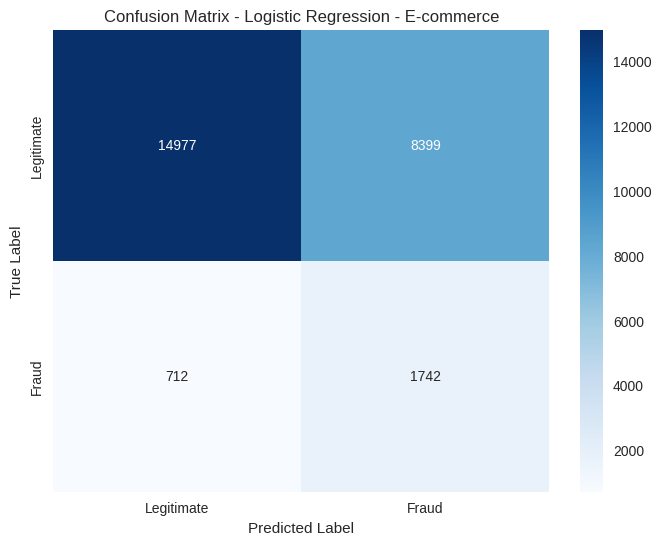

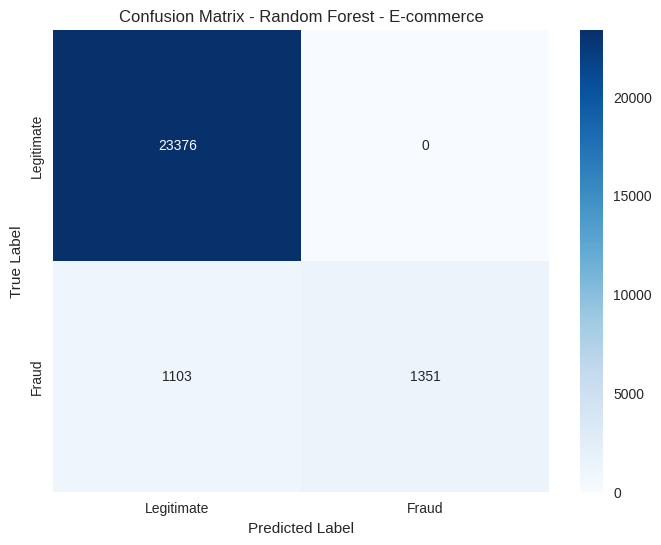

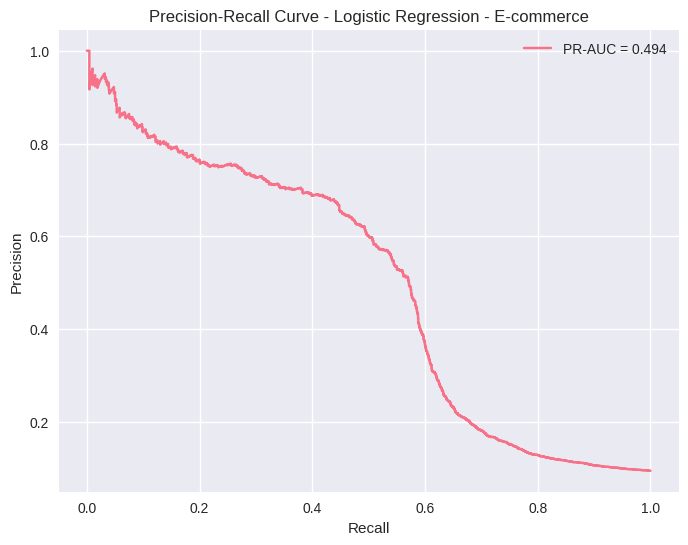

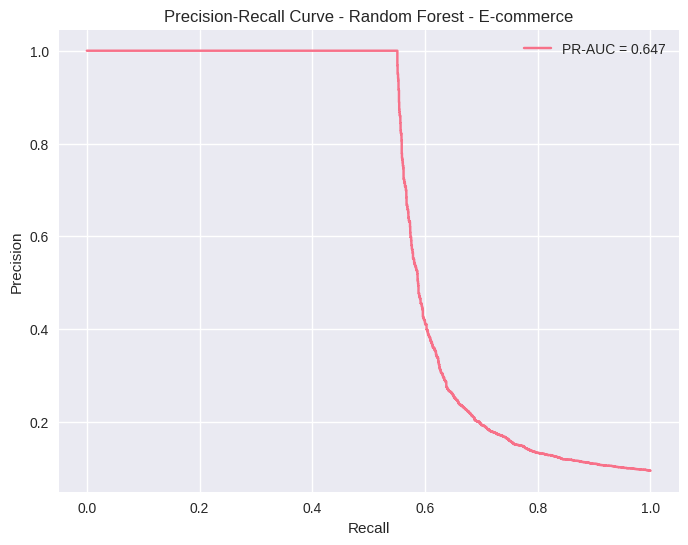


Training models for Credit Card
Training set size: 226980
Test set size: 56746
Categorical columns: []
Numerical columns: ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount']

1. Training Logistic Regression...

2. Training Random Forest...

Results for Credit Card

LOGISTIC_REGRESSION:
  Precision: 0.056
  Recall: 0.874
  F1-Score: 0.106
  ROC-AUC: 0.966
  PR-AUC: 0.707

RANDOM_FOREST:
  Precision: 0.886
  Recall: 0.737
  F1-Score: 0.805
  ROC-AUC: 0.965
  PR-AUC: 0.767


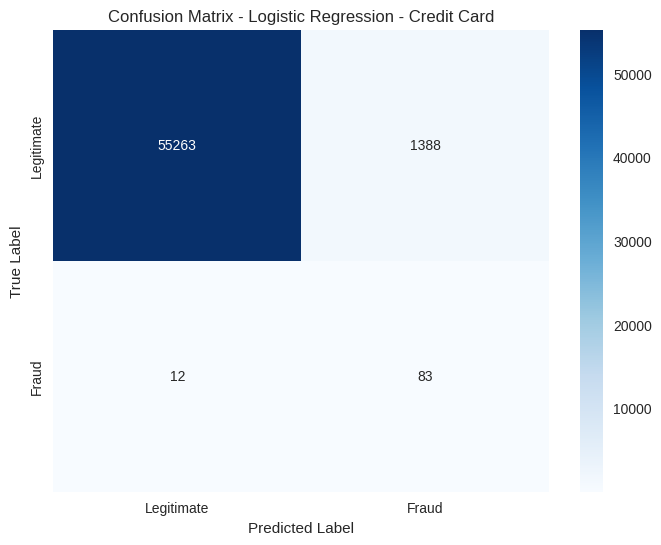

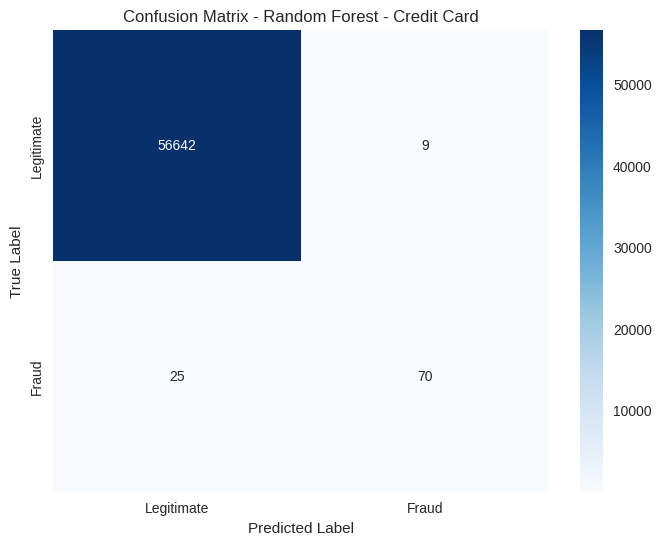

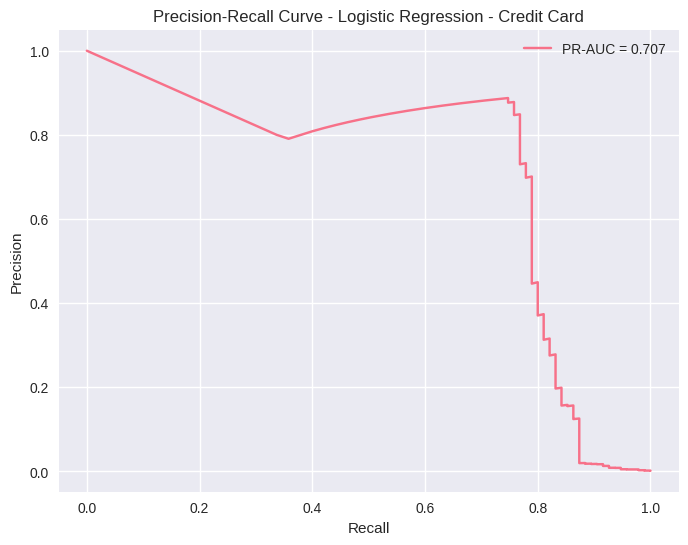

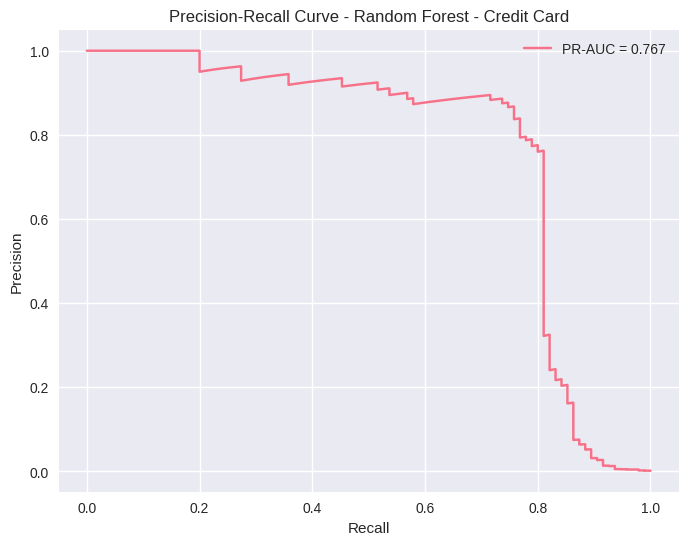

In [18]:
def train_and_evaluate_models(X, y, dataset_name):
    """
    Train and evaluate both Logistic Regression and Random Forest models
    """
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    print(f"\n{'='*50}")
    print(f"Training models for {dataset_name}")
    print(f"{'='*50}")
    print(f"Training set size: {X_train.shape[0]}")
    print(f"Test set size: {X_test.shape[0]}")
    
    models = {}
    results = {}
    
    # Identify categorical and numerical columns
    categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()
    numerical_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
    
    print(f"Categorical columns: {categorical_cols}")
    print(f"Numerical columns: {numerical_cols}")
    
    # Train Logistic Regression
    print("\n1. Training Logistic Regression...")
    lr_model = FraudDetectionModel('logistic_regression')
    y_pred_lr, y_pred_proba_lr, X_test_scaled = lr_model.train_with_categorical(
        X_train, y_train, X_test, y_test, categorical_cols, numerical_cols
    )
    results_lr = lr_model.evaluate(y_test, y_pred_lr, y_pred_proba_lr)
    
    models['logistic_regression'] = lr_model
    results['logistic_regression'] = results_lr
    
    # Train Random Forest
    print("\n2. Training Random Forest...")
    rf_model = FraudDetectionModel('random_forest')
    y_pred_rf, y_pred_proba_rf, _ = rf_model.train_with_categorical(
        X_train, y_train, X_test, y_test, categorical_cols, numerical_cols
    )
    results_rf = rf_model.evaluate(y_test, y_pred_rf, y_pred_proba_rf)
    
    models['random_forest'] = rf_model
    results['random_forest'] = results_rf
    
    # Print results
    print(f"\n{'='*50}")
    print(f"Results for {dataset_name}")
    print(f"{'='*50}")
    
    for model_name, result in results.items():
        print(f"\n{model_name.upper()}:")
        print(f"  Precision: {result['precision']:.3f}")
        print(f"  Recall: {result['recall']:.3f}")
        print(f"  F1-Score: {result['f1_score']:.3f}")
        print(f"  ROC-AUC: {result['roc_auc']:.3f}")
        print(f"  PR-AUC: {result['pr_auc']:.3f}")
    
    # Plot confusion matrices
    for model_name, result in results.items():
        models[model_name].plot_confusion_matrix(
            result['confusion_matrix'], 
            f"{model_name.replace('_', ' ').title()} - {dataset_name}"
        )
    
    # Plot PR curves
    for model_name, result in results.items():
        if model_name == 'logistic_regression':
            y_pred_proba = y_pred_proba_lr
        else:
            y_pred_proba = y_pred_proba_rf
        
        models[model_name].plot_pr_curve(
            y_test, y_pred_proba,
            f"{model_name.replace('_', ' ').title()} - {dataset_name}"
        )
    
    return models, results, X_test, X_test_scaled

import joblib
import os

os.makedirs('../data/trained', exist_ok=True)
os.makedirs('../data/SHAP', exist_ok=True)

# Train models and get test splits for both datasets
ecom_models, ecom_results, ecom_X_test, ecom_X_test_scaled = train_and_evaluate_models(X_ecom, y_ecom, "E-commerce")
cc_models, cc_results, cc_X_test, cc_X_test_scaled = train_and_evaluate_models(X_cc, y_cc, "Credit Card")

# Save the trained Random Forest models for both datasets
joblib.dump(ecom_models['random_forest'].model, '../data/trained/random_forest_ecom.joblib')
joblib.dump(cc_models['random_forest'].model, '../data/trained/random_forest_cc.joblib')

# Save the test sets for SHAP analysis
ecom_X_test.to_csv('../data/SHAP/X_ecom_test.csv', index=False)
cc_X_test.to_csv('../data/SHAP/X_cc_test.csv', index=False)
pd.DataFrame(ecom_X_test_scaled, columns=ecom_X_test.columns).to_csv('../data/SHAP/X_ecom_test_scaled.csv', index=False)
pd.DataFrame(cc_X_test_scaled, columns=cc_X_test.columns).to_csv('../data/SHAP/X_cc_test_scaled.csv', index=False)

# Model Comparision and Analysis

In [12]:
# Create comparison dataframe
def create_comparison_df(results_dict, dataset_name):
    """Create a comparison dataframe for model results"""
    comparison_data = []
    
    for model_name, results in results_dict.items():
        comparison_data.append({
            'Dataset': dataset_name,
            'Model': model_name.replace('_', ' ').title(),
            'Precision': results['precision'],
            'Recall': results['recall'],
            'F1-Score': results['f1_score'],
            'ROC-AUC': results['roc_auc'],
            'PR-AUC': results['pr_auc']
        })
    
    return pd.DataFrame(comparison_data)

# Create comparison dataframes
ecom_comparison = create_comparison_df(ecom_results, "E-commerce")
cc_comparison = create_comparison_df(cc_results, "Credit Card")

# Combine results
all_results = pd.concat([ecom_comparison, cc_comparison], ignore_index=True)

print("Model Performance Comparison:")
print("="*80)
print(all_results.round(3))

# Find best models for each dataset
print("\nBest Models by Dataset:")
print("="*40)

for dataset in ['E-commerce', 'Credit Card']:
    dataset_results = all_results[all_results['Dataset'] == dataset]
    best_model = dataset_results.loc[dataset_results['PR-AUC'].idxmax()]
    print(f"\n{dataset} Dataset:")
    print(f"  Best Model: {best_model['Model']}")
    print(f"  PR-AUC: {best_model['PR-AUC']:.3f}")
    print(f"  F1-Score: {best_model['F1-Score']:.3f}")

Model Performance Comparison:
       Dataset                Model  Precision  Recall  F1-Score  ROC-AUC  \
0   E-commerce  Logistic Regression      0.172   0.710     0.277    0.765   
1   E-commerce        Random Forest      1.000   0.551     0.710    0.784   
2  Credit Card  Logistic Regression      0.056   0.874     0.106    0.966   
3  Credit Card        Random Forest      0.886   0.737     0.805    0.965   

   PR-AUC  
0   0.494  
1   0.647  
2   0.707  
3   0.767  

Best Models by Dataset:

E-commerce Dataset:
  Best Model: Random Forest
  PR-AUC: 0.647
  F1-Score: 0.710

Credit Card Dataset:
  Best Model: Random Forest
  PR-AUC: 0.767
  F1-Score: 0.805


# Feature Importance Analysis (Random Forest)

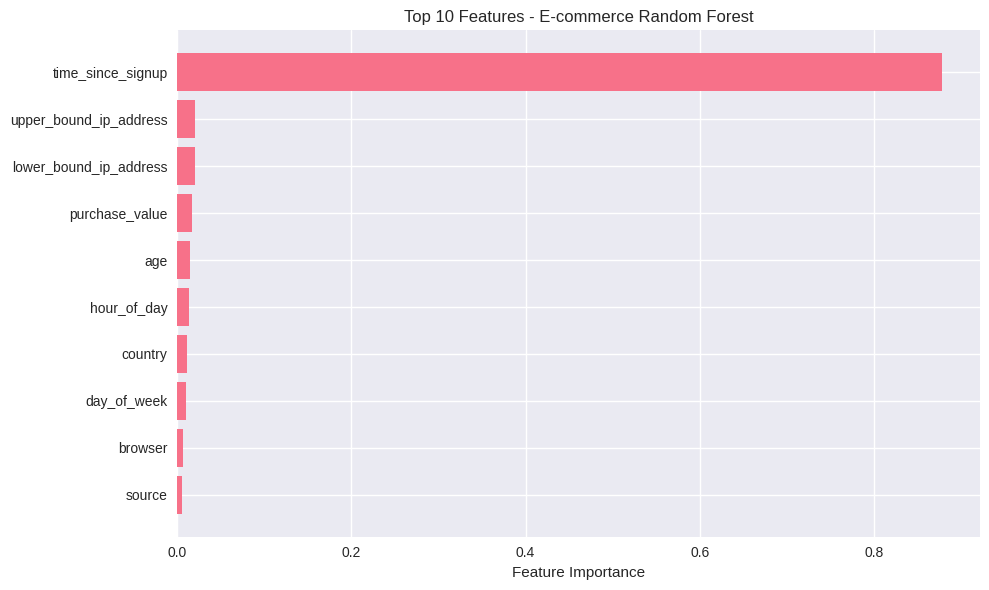


Top 10 features for E-commerce Random Forest:
                   feature  importance
8        time_since_signup      0.8781
6   upper_bound_ip_address      0.0205
5   lower_bound_ip_address      0.0201
0           purchase_value      0.0172
4                      age      0.0149
9              hour_of_day      0.0134
7                  country      0.0115
10             day_of_week      0.0096
2                  browser      0.0065
1                   source      0.0056


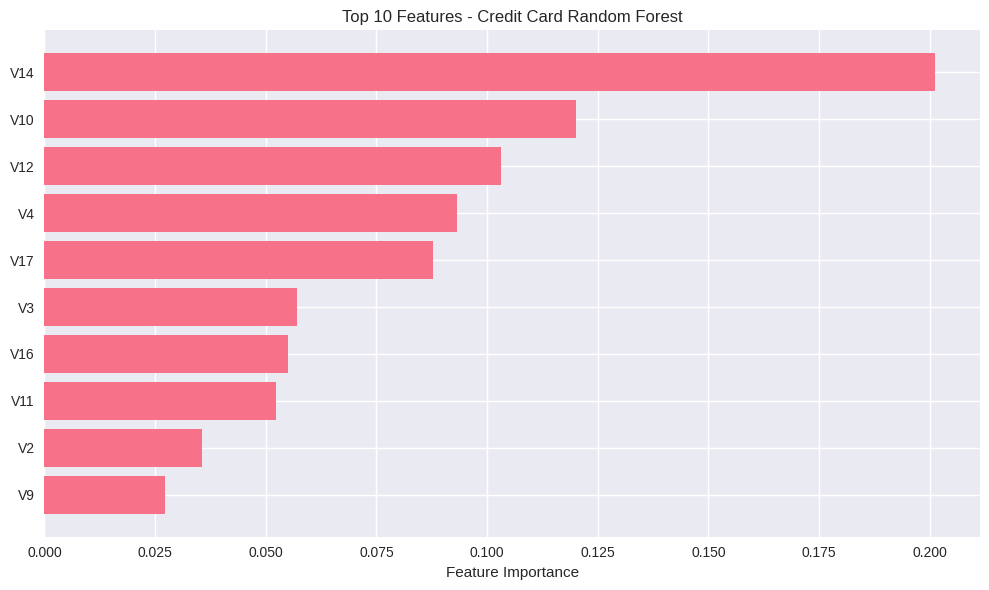


Top 10 features for Credit Card Random Forest:
   feature  importance
14     V14      0.2013
10     V10      0.1202
12     V12      0.1032
4       V4      0.0932
17     V17      0.0877
3       V3      0.0570
16     V16      0.0551
11     V11      0.0524
2       V2      0.0356
9       V9      0.0272


In [13]:
# Plot feature importance for Random Forest models
def plot_feature_importance(model, title, top_n=10):
    """Plot feature importance for Random Forest models"""
    importance_df = model.get_feature_importance()
    
    if importance_df is not None:
        plt.figure(figsize=(10, 6))
        top_features = importance_df.head(top_n)
        
        plt.barh(range(len(top_features)), top_features['importance'])
        plt.yticks(range(len(top_features)), top_features['feature'])
        plt.xlabel('Feature Importance')
        plt.title(f'Top {top_n} Features - {title}')
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.show()
        
        print(f"\nTop {top_n} features for {title}:")
        print(top_features[['feature', 'importance']].round(4))

# Plot feature importance for both datasets
plot_feature_importance(ecom_models['random_forest'], "E-commerce Random Forest")
plot_feature_importance(cc_models['random_forest'], "Credit Card Random Forest")

# Model Selection JUstification

In [14]:
# Model selection analysis
print("MODEL SELECTION ANALYSIS")
print("="*50)

print("\n1. E-COMMERCE DATASET:")
print("-"*30)
ecom_lr_score = ecom_results['logistic_regression']['pr_auc']
ecom_rf_score = ecom_results['random_forest']['pr_auc']

if ecom_lr_score > ecom_rf_score:
    print(f"✅ Logistic Regression performs better (PR-AUC: {ecom_lr_score:.3f} vs {ecom_rf_score:.3f})")
    print("   Justification: Better performance on imbalanced data with interpretable results")
else:
    print(f"✅ Random Forest performs better (PR-AUC: {ecom_rf_score:.3f} vs {ecom_lr_score:.3f})")
    print("   Justification: Captures complex non-linear patterns in fraud detection")

print("\n2. CREDIT CARD DATASET:")
print("-"*30)
cc_lr_score = cc_results['logistic_regression']['pr_auc']
cc_rf_score = cc_results['random_forest']['pr_auc']

if cc_lr_score > cc_rf_score:
    print(f"✅ Logistic Regression performs better (PR-AUC: {cc_lr_score:.3f} vs {cc_rf_score:.3f})")
    print("   Justification: Better performance on imbalanced data with interpretable results")
else:
    print(f"✅ Random Forest performs better (PR-AUC: {cc_rf_score:.3f} vs {cc_lr_score:.3f})")
    print("   Justification: Captures complex non-linear patterns in fraud detection")

print("\n3. OVERALL RECOMMENDATIONS:")
print("-"*30)
print("• Use PR-AUC as primary metric for imbalanced fraud detection")
print("• Consider model interpretability vs performance trade-off")
print("• Random Forest provides feature importance insights")
print("• Logistic Regression offers better interpretability for business stakeholders")

MODEL SELECTION ANALYSIS

1. E-COMMERCE DATASET:
------------------------------
✅ Random Forest performs better (PR-AUC: 0.647 vs 0.494)
   Justification: Captures complex non-linear patterns in fraud detection

2. CREDIT CARD DATASET:
------------------------------
✅ Random Forest performs better (PR-AUC: 0.767 vs 0.707)
   Justification: Captures complex non-linear patterns in fraud detection

3. OVERALL RECOMMENDATIONS:
------------------------------
• Use PR-AUC as primary metric for imbalanced fraud detection
• Consider model interpretability vs performance trade-off
• Random Forest provides feature importance insights
• Logistic Regression offers better interpretability for business stakeholders
